In [1]:
import numpy as np
import tifffile
import os
import napari
import matplotlib.pyplot as plt

In [2]:
#Create data, with 3D gauss dots

In [3]:
import math
def generateGaussPSF(shape, sigma=10):
    #shape = (32,32,32)
    z_mg = np.linspace(-shape[0],shape[0] ,shape[0], dtype=np.float32)
    y_mg = np.linspace(-shape[1],shape[1] ,shape[1], dtype=np.float32)
    x_mg = np.linspace(-shape[2],shape[2] ,shape[2], dtype=np.float32)

    z_mg, y_mg, x_mg = np.meshgrid( z_mg, y_mg, x_mg)

    data = 1/sigma/math.sqrt(2*math.pi) * np.exp( -0.5 * ( np.square(z_mg) + np.square(y_mg) + np.square(x_mg) ) / sigma/sigma )

    return data

In [4]:
psf=generateGaussPSF((32,32,32), sigma=8)
psf_norm = psf/np.sum(psf)

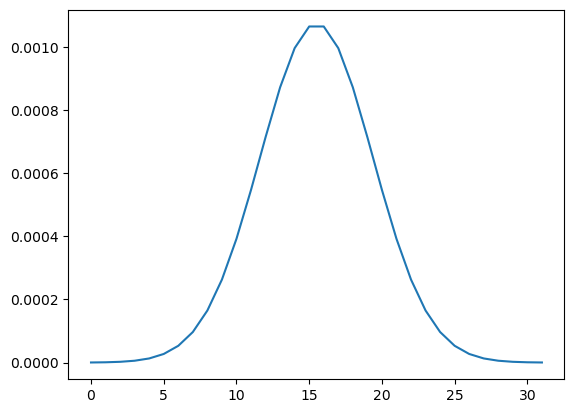

In [5]:
plt.plot(psf_norm[16,16,:])

In [6]:
import napari
napari.view_image(psf_norm)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 15.5, 15.5), zoom=15.853124999999999, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 32.0, 1.0), (0.0, 32.0, 1.0), (0.0, 32.0, 1.0)), current_step=(16, 16, 16), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'psf_norm' at 0x290e8c4e0a0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=False

In [7]:
print(psf_norm.shape)
print(psf_norm.dtype)
print(np.sum(psf_norm))
print(psf_norm.min())
print(psf_norm.max())

(32, 32, 32)
float32
1.0000001
4.1199567e-14
0.0010644229


In [8]:
import scipy
#Create data array that will be used for deconvolution benchmarking
size = 256
data0 = np.zeros((size,size,size), dtype=np.float32)
data0[int(size/2),int(size/2),int(size/2)]=1e5

#Convolute
data_convolved = scipy.signal.convolve(data0, psf_norm, mode='same')

print(f"dataconv max, min: {data_convolved.max()}, {data_convolved.min()}")
#Some values are negative, and they shouldn't
data_convolved_fix = np.where(data_convolved<0, 0, data_convolved)
print(f"data_convolved_fix max, min: {data_convolved_fix.max()}, {data_convolved_fix.min()}")

#Add noise
rng = np.random.default_rng()
data = rng.poisson(lam = data_convolved_fix).astype(np.float32)
print(f"data max, min: {data.max()}, {data.min()}")


dataconv max, min: 106.44227600097656, -1.6075102394097485e-05
data_convolved_fix max, min: 106.44227600097656, 0.0
data max, min: 123.0, 0.0


In [9]:
data.dtype

dtype('float32')

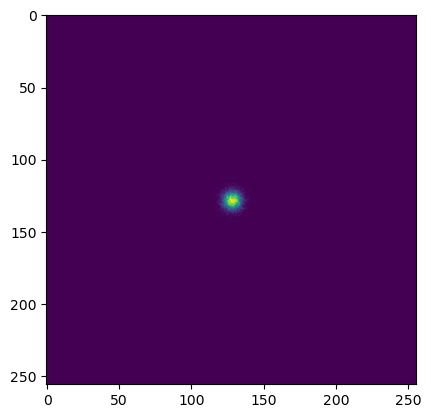

In [10]:
import matplotlib.pyplot as plt
plt.imshow(data[int(size/2),:,:])

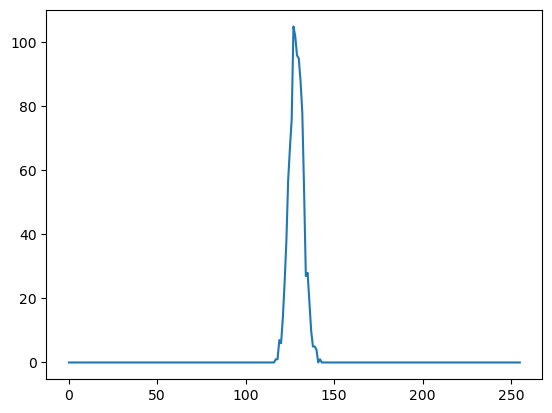

In [11]:
import matplotlib.pyplot as plt
plt.plot(data[int(size/2),int(size/2),:])

In [12]:
import napari
napari.view_image(data)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 127.5, 127.5), zoom=1.9816406249999998, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 256.0, 1.0), (0.0, 256.0, 1.0), (0.0, 256.0, 1.0)), current_step=(128, 128, 128), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'data' at 0x2909a16e0d0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=F

In [13]:
from scipy.optimize import curve_fit

def gaussian(coords3d, a, sigma):
    #Assume it is centered at zero
    return a*np.exp(-0.5*(coords3d[0]**2 + coords3d[1]**2+ coords3d[2]**2)/ sigma**2 )

def getFitGaussParamsOf3DDataAtCentre(data3d, crop_centre_width=None):
    shape = data3d.shape
    centre = [int(w0/2) for w0 in shape]

    #crop a size of 32x32x32
    #data0 = data3d[ centre[0]-16:centre[0]+16, centre[1]-16:centre[1]+16, centre[2]-16:centre[2]+16]
    #range0=16
    data0=None
    if crop_centre_width is None:
        data0=data3d
        range0=int(data3d.shape[0]/2) #Assumes it is a cube
    else:
        range0 = int(crop_centre_width/2)
        data0 = data3d[ centre[0]-range0:centre[0]+range0, centre[1]-range0:centre[1]+range0, centre[2]-range0:centre[2]+range0]
    xrange=np.arange(-range0,range0)
    yrange = np.array(xrange)
    zrange = np.array(xrange)

    #guess amplitude
    a0=data0.max()
    xx,yy,zz = np.meshgrid(xrange,yrange,zrange)

    xx_flat= xx.flatten()
    yy_flat = yy.flatten()
    zz_flat = zz.flatten()

    #coordsvalues = list(zip(xx_flat, yy_flat, zz_flat))

    coordsvalues = np.array([zz_flat,yy_flat,xx_flat])
    #print(coordsvalues.shape)
    
    data0_flat = data0.flatten()

    popt, pcov = curve_fit(gaussian,coordsvalues, data0_flat, p0=[a0,range0])
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

In [14]:
#Second value is the sigma (~gaussian width)
getFitGaussParamsOf3DDataAtCentre(data, crop_centre_width=32)

(array([105.46541466,   3.92240997]), array([0.20940341, 0.00402174]))

In [15]:
getFitGaussParamsOf3DDataAtCentre(psf_norm, crop_centre_width=None)

(array([1.06447860e-03, 3.90739178e+00]),
 array([1.47550201e-06, 2.79688599e-03]))

In [16]:
#Test
import RedLionfishDeconv.RLDeconv3DScipy as rlsp
func0 = rlsp.doRLDeconvolution_DL2_4
res0 = func0(data,psf_norm, niter=2)

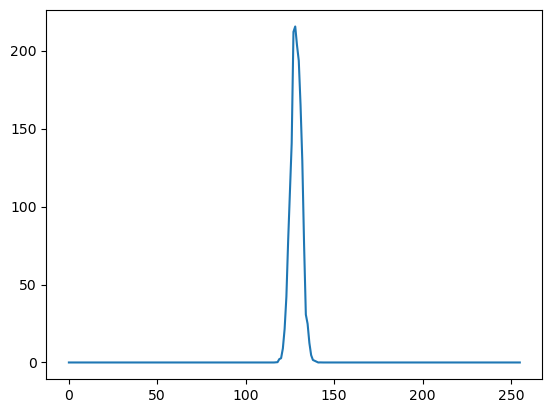

In [17]:
plt.plot(res0[int(size/2),int(size/2),:])

In [18]:
getFitGaussParamsOf3DDataAtCentre(res0, crop_centre_width=32)

(array([222.06562732,   3.09374551]), array([0.48511306, 0.00349003]))

## See the effect of RL deconvolution on the gaussian width

In [19]:
#See the effect of RL deconvolution on the gaussian width
import RedLionfishDeconv.RLDeconv3DReiknaOCL as rlocl
import RedLionfishDeconv.RLDeconv3DScipy as rlsp
import skimage.restoration as rlsk
import time

def rl_scikit_wrapper(data, psf, niter):
    return rlsk.richardson_lucy(data,psf, num_iter=niter, clip=False, filter_epsilon=1e-16)

rlfuncs = [rlsp.doRLDeconvolution_DL2_4, rlocl.nonBlock_RLDeconvolutionReiknaOCL, rl_scikit_wrapper]

results=[]
for rlfunc0 in rlfuncs:
    print(rlfunc0.__name__)
    res_withthisfunc=[]
    for iter0 in range(1,10):
        starttime = time.perf_counter()
        res0 = rlfunc0(data,psf_norm,niter=iter0)
        endtime = time.perf_counter()
        exectime = endtime-starttime

        #Get gauss width
        g_fit_params, perr = getFitGaussParamsOf3DDataAtCentre(res0,crop_centre_width=32)

        print(f"iter: {iter0}, g_fit_params:{g_fit_params}, perr:{perr}, exectime:{exectime}")

        res_withthisfunc.append( [iter0, g_fit_params, perr, exectime])
    results.append([rlfunc0.__name__ ,res_withthisfunc])

doRLDeconvolution_DL2_4
iter: 1, g_fit_params:[164.75356077   3.40859368], perr:[0.33005897 0.00352629], exectime:2.311669100000003
iter: 2, g_fit_params:[222.06562732   3.09374551], perr:[0.48511306 0.00349003], exectime:4.7682566999999985
iter: 3, g_fit_params:[276.8721738    2.87639504], perr:[0.66694681 0.00357804], exectime:5.876661600000006
iter: 4, g_fit_params:[329.12126864   2.71523257], perr:[0.86932603 0.00370356], exectime:7.7213092
iter: 5, g_fit_params:[378.90600314   2.58988407], perr:[1.08727568 0.00383779], exectime:8.791402500000004
iter: 6, g_fit_params:[426.36809317   2.48898884], perr:[1.3170056  0.00397018], exectime:12.709776599999998
iter: 7, g_fit_params:[471.66229729   2.40564598], perr:[1.55554737 0.00409702], exectime:11.847707400000004
iter: 8, g_fit_params:[514.94122116   2.33539173], perr:[1.80068376 0.00421716], exectime:13.654327699999996
iter: 9, g_fit_params:[556.34917959   2.27519543], perr:[2.05064611 0.00433054], exectime:14.312566900000007
nonBloc

In [26]:
results

[['doRLDeconvolution_DL2_4',
  [[1,
    array([164.75356077,   3.40859368]),
    array([0.33005897, 0.00352629]),
    2.311669100000003],
   [2,
    array([222.06562732,   3.09374551]),
    array([0.48511306, 0.00349003]),
    4.7682566999999985],
   [3,
    array([276.8721738 ,   2.87639504]),
    array([0.66694681, 0.00357804]),
    5.876661600000006],
   [4,
    array([329.12126864,   2.71523257]),
    array([0.86932603, 0.00370356]),
    7.7213092],
   [5,
    array([378.90600314,   2.58988407]),
    array([1.08727568, 0.00383779]),
    8.791402500000004],
   [6,
    array([426.36809317,   2.48898884]),
    array([1.3170056 , 0.00397018]),
    12.709776599999998],
   [7,
    array([471.66229729,   2.40564598]),
    array([1.55554737, 0.00409702]),
    11.847707400000004],
   [8,
    array([514.94122116,   2.33539173]),
    array([1.80068376, 0.00421716]),
    13.654327699999996],
   [9,
    array([556.34917959,   2.27519543]),
    array([2.05064611, 0.00433054]),
    14.31256690000

In [27]:
import pickle
with open('RL_bencm_gauss_progress_ASUS_Avivo_14.pkl', 'wb' ) as file0:
    pickle.dump(results,file0)

plot results

In [28]:
it1=results[0][1]
it1

[[1,
  array([164.75356077,   3.40859368]),
  array([0.33005897, 0.00352629]),
  2.311669100000003],
 [2,
  array([222.06562732,   3.09374551]),
  array([0.48511306, 0.00349003]),
  4.7682566999999985],
 [3,
  array([276.8721738 ,   2.87639504]),
  array([0.66694681, 0.00357804]),
  5.876661600000006],
 [4,
  array([329.12126864,   2.71523257]),
  array([0.86932603, 0.00370356]),
  7.7213092],
 [5,
  array([378.90600314,   2.58988407]),
  array([1.08727568, 0.00383779]),
  8.791402500000004],
 [6,
  array([426.36809317,   2.48898884]),
  array([1.3170056 , 0.00397018]),
  12.709776599999998],
 [7,
  array([471.66229729,   2.40564598]),
  array([1.55554737, 0.00409702]),
  11.847707400000004],
 [8,
  array([514.94122116,   2.33539173]),
  array([1.80068376, 0.00421716]),
  13.654327699999996],
 [9,
  array([556.34917959,   2.27519543]),
  array([2.05064611, 0.00433054]),
  14.312566900000007]]

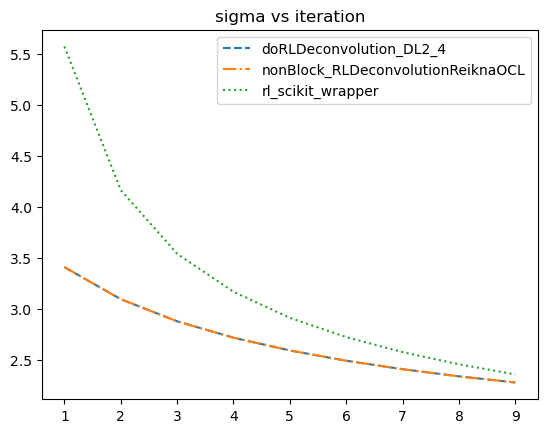

In [29]:
#sigma vs iteration
plt.figure()
lines = ["--","-.",":"]
from itertools import cycle
linecycler = cycle(lines)

for i0,it0 in enumerate(results):
    funcname = it0[0]
    
    xvalues=[]
    yvalues=[]
    for it1 in it0[1]:
        #print(it1)
        iter = it1[0]
        sigma = it1[1][1]
        
        xvalues.append(iter)
        yvalues.append(sigma)

    plt.plot(xvalues,yvalues, label=funcname, ls=next(linecycler))
    plt.legend()
    plt.title("sigma vs iteration")

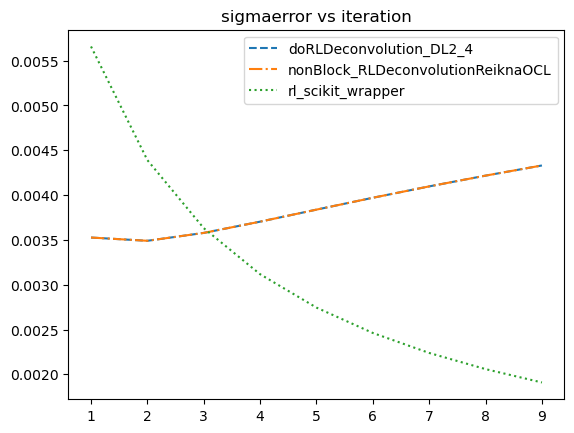

In [30]:
#sigmaerror vs iteration
plt.figure()
lines = ["--","-.",":"]
from itertools import cycle
linecycler = cycle(lines)

for i0,it0 in enumerate(results):
    funcname = it0[0]
    
    xvalues=[]
    yvalues=[]
    for it1 in it0[1]:
        #print(it1)
        iter = it1[0]
        sigma = it1[2][1]
        
        xvalues.append(iter)
        yvalues.append(sigma)

    plt.plot(xvalues,yvalues, label=funcname, ls=next(linecycler))
    plt.legend()
    plt.title("sigmaerror vs iteration")

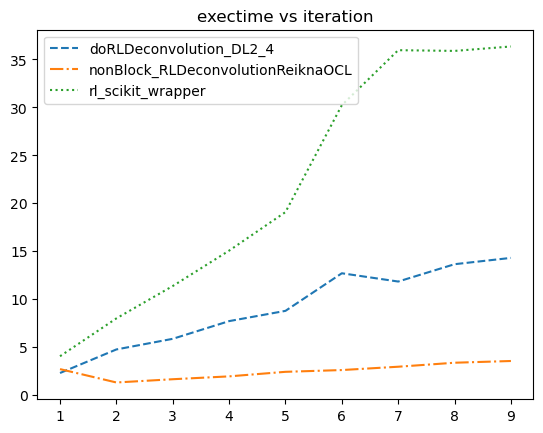

In [32]:
#exectime vs iteration
plt.figure()
lines = ["--","-.",":"]
from itertools import cycle
linecycler = cycle(lines)

for i0,it0 in enumerate(results):
    funcname = it0[0]
    
    xvalues=[]
    yvalues=[]
    for it1 in it0[1]:
        #print(it1)
        iter = it1[0]
        sigma = it1[3]
        
        xvalues.append(iter)
        yvalues.append(sigma)

    plt.plot(xvalues,yvalues, label=funcname, ls=next(linecycler))
    plt.legend()
    plt.title("exectime vs iteration")